In [ ]:
import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np

import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
import bionty as bt

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [3]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../da6ao55o.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [4]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert
FYI: scPrint is not attached to a `Trainer`.


In [5]:
def revert_to_raw(adata):
    res = adata.X
    res = np.exp(res) - 1
    res = (
        (res.T / np.array([res[i][res[i] != 0].min() for i in range(res.shape[0])]))
        .round()
        .T
    )  # .sum()
    adata.X = res
    return adata

# another one (human mouse)

In [6]:
human = sc.read("./normalize_log/task4_human.h5ad")
mouse = sc.read("./normalize_log/task4_mouse.h5ad")

In [7]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [8]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [9]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [10]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human_p = preprocessor(human.copy())
mouse_p = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4336 genes not known to the ontology
Removed 0 duplicate genes
Added 53976 genes in the ontology but not present in the dataset
starting QC
Seeing 5689 outliers (10.77% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70611
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism

In [ ]:
bt.CellType.search("connecting tubule")[0].parents.filter()[
    1
].parents.filter()  # [2].parents.filter().df()

<QuerySet [CellType(uid='SwkRbOq9', name='renal intercalated cell', ontology_id='CL:0005010', synonyms='intercalated cell', description='A Cuboidal Epithelial Cell Of The Kidney That Regulates Acid/Base Balance.', space_id=1, created_by_id=1, source_id=32, created_at=2025-06-30 16:34:07 UTC), CellType(uid='6GhkEiYv', name='kidney connecting tubule epithelial cell', ontology_id='CL:1000768', description='Any Nephron Tubule Epithelial Cell That Is Part Of Some Renal Connecting Tubule.', space_id=1, created_by_id=1, source_id=32, created_at=2025-06-30 16:34:07 UTC)]>

In [49]:
mouse_p.obs.celltype.value_counts()

celltype
Fibroblast                               7516
Endothelial cell                         5911
Macrophage                               2833
Proximal tubule cell                     2104
Astrocyte                                2082
Oligodendrocyte                          1416
Epithelial cell                          1151
Dendritic cell                           1111
Smooth muscle cell                       1089
Monocyte                                 1002
Ascending loop of Henle                   868
Neutrophil                                773
T cell                                    505
Intercalated cells of collecting duct     486
Erythroid cell                            415
Microglia                                 390
B cell                                    366
Distal convoluted tubule                  327
Hepatocyte                                299
Connecting tubule cell                    285
Plasma cell                               175
Cardiomyocyte            

In [14]:
human_p.obs.celltype.value_counts()

celltype
Loop of Henle                                               8431
Smooth muscle cell                                          8323
Monocyte                                                    5511
Epithelial cell                                             4398
Intercalated cell                                           4392
Sinusoidal endothelial cell                                 3983
Endothelial cell (APC)                                      3817
Macrophage                                                  3750
Dendritic cell                                              3653
Epithelial cell (intermediated)                             1782
T cell                                                      1492
Stromal cell                                                1383
B cell (Plasmocyte)                                          614
Neutrophil                                                   381
Mast cell                                                    175
B cell          

In [11]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
    "Proximal tubule cellAscending loop of Henle": "CL:1000909",
    "Intercalated cells of collecting duct": "CL:0005010",
    "Erythroid cell": "CL:0000764",
    "Microglia": "CL:0000129",
    "Distal convoluted tubule": "CL:1000849",
    "Connecting tubule cell": "CL:1000768",
}

res = (
    bt.CellType.standardize(
        mouse_p.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Macrophage': 'CL:0000235',
 'Astrocyte': 'CL:0000127',
 'Oligodendrocyte': 'CL:0000128',
 'Epithelial cell': 'CL:0000066',
 'Dendritic cell': 'CL:0000451',
 'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Neutrophil': 'CL:0000775',
 'Hepatocyte': 'CL:0000182',
 'Plasma cell': 'CL:0000786',
 'Cardiomyocyte': 'CL:0000746',
 'Neural progenitor cell': 'CL:0011020',
 'Erythroblast': 'CL:0000765',
 'Mast cell': 'CL:0000097',
 'Ependymal cell': 'CL:0000065',
 'Mesenchymal cell': 'CL:0008019',
 'Basal cell': 'CL:0000646',
 'Myocyte': 'CL:0000187',
 'Enterocyte': 'CL:0000584',
 'Unknown': 'unknown',
 'Chondrocyte': 'CL:0000138',
 'Megakaryocyte': 'CL:0000556',
 'Goblet cell': 'CL:0000160',
 'Striated muscle cell': 'CL:0000737',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': '

In [12]:
mouse_p.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in mouse_p.obs["celltype"].values
]

In [13]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
}

res = (
    bt.CellType.standardize(
        human_p.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Epithelial cell': 'CL:0000066',
 'Intercalated cell': 'CL:0005010',
 'Macrophage': 'CL:0000235',
 'Dendritic cell': 'CL:0000451',
 'Stromal cell': 'CL:0000499',
 'Neutrophil': 'CL:0000775',
 'Mast cell': 'CL:0000097',
 'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Ureteric bud cell': 'CL:4030066',
 'Goblet cell': 'CL:0000160',
 'Stratified epithelial cell': 'CL:0000079',
 'Myeloid cell': 'CL:0000763',
 'Basal cell': 'CL:0000646',
 'Proliferating T cell': 'CL:4033069',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': 'CL:0000499',
 'Epithelial cell (intermediated)': 'CL:0000066'}

In [14]:
human_p.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in human_p.obs["celltype"].values
]


In [15]:
embed = Embedder(
    how="random expr",
    max_len=3000,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)

In [16]:
spe_a, metrics = embed(model, human_p)
spe_b, metrics = embed(model, mouse_p)

not on wandb, could not set name


 76%|███████▌  | 625/826 [03:14<00:57,  3.51it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 's

100%|██████████| 826/826 [11:05<00:00,  1.24it/s]   


logging the anndata
AnnData object with n_obs × n_vars = 12747 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_t

100%|██████████| 492/492 [02:19<00:00,  3.53it/s]


logging the anndata
AnnData object with n_obs × n_vars = 31474 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_t

In [17]:
pred = ad.concat([spe_a, spe_b])
pred

[autoreload of scprint.tasks.denoise failed: Traceback (most recent call last):
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ml4ig1/miniconda3/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/d

AnnData object with n_obs × n_vars = 84285 × 0
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_type_ontology_term_id', 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id

In [18]:
pred.write("./data/task4_denoised.h5ad")

... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical


In [21]:
from scprint.tasks.cell_emb import display_confusion_matrix


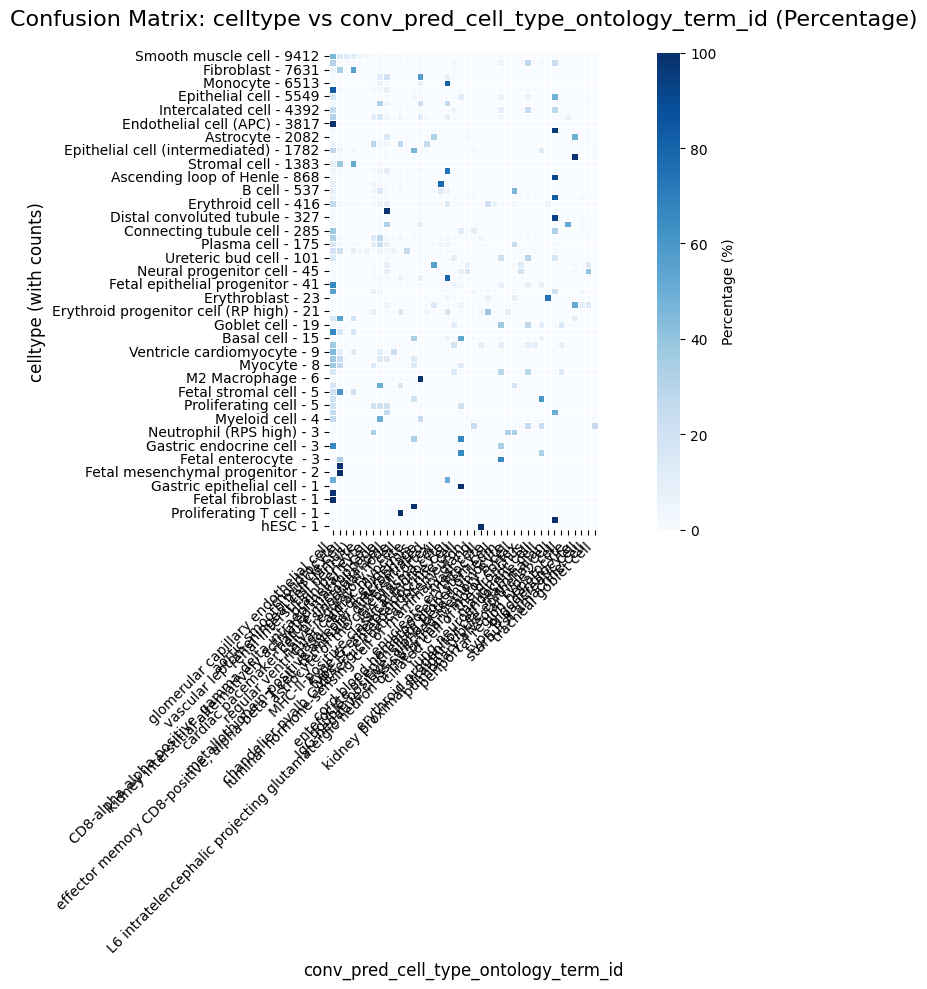

In [23]:
display_confusion_matrix(pred, true="celltype")

... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical


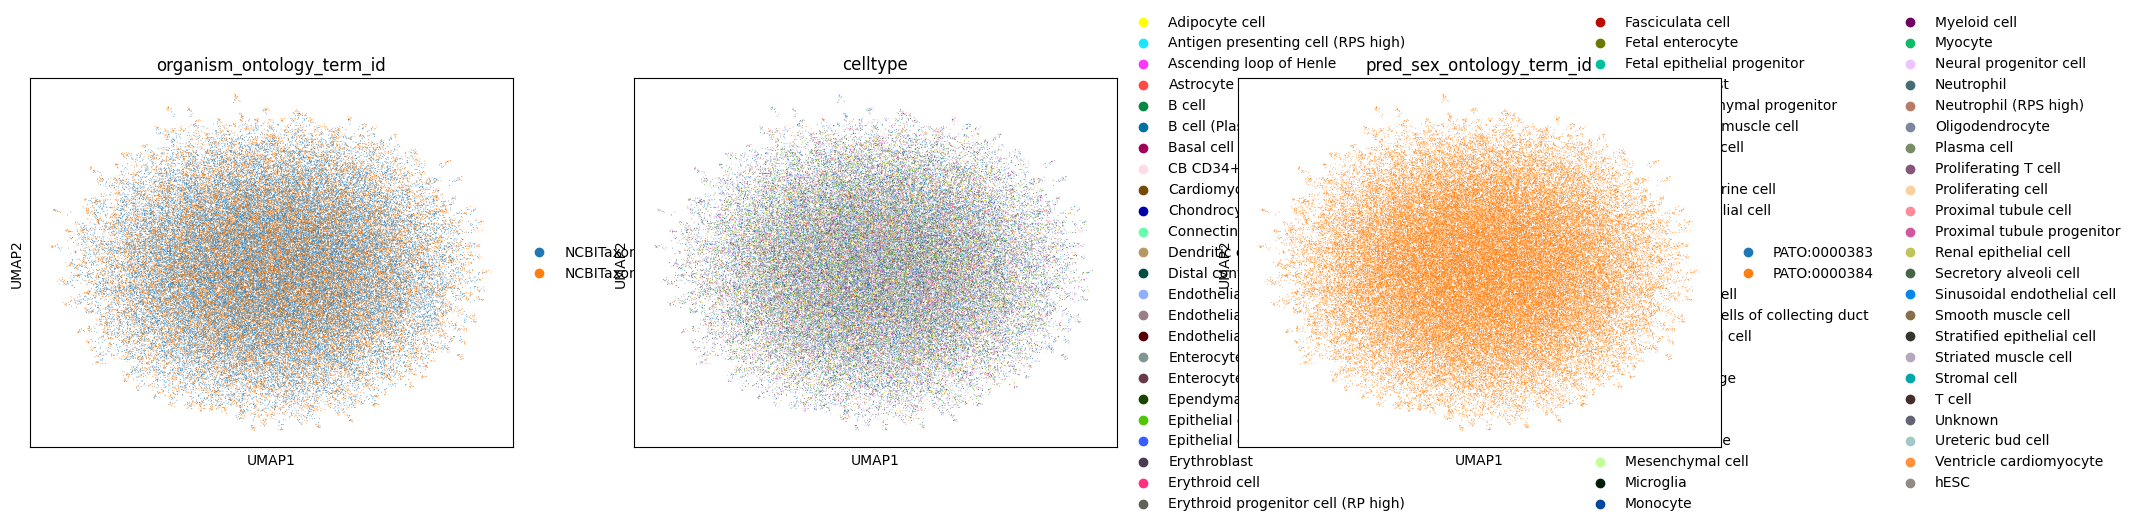

In [23]:
sc.pp.neighbors(pred, use_rep="scprint_emb_sex_ontology_term_id")
sc.tl.umap(pred)
sc.pl.umap(
    pred, color=["organism_ontology_term_id", "celltype", "pred_sex_ontology_term_id"]
)

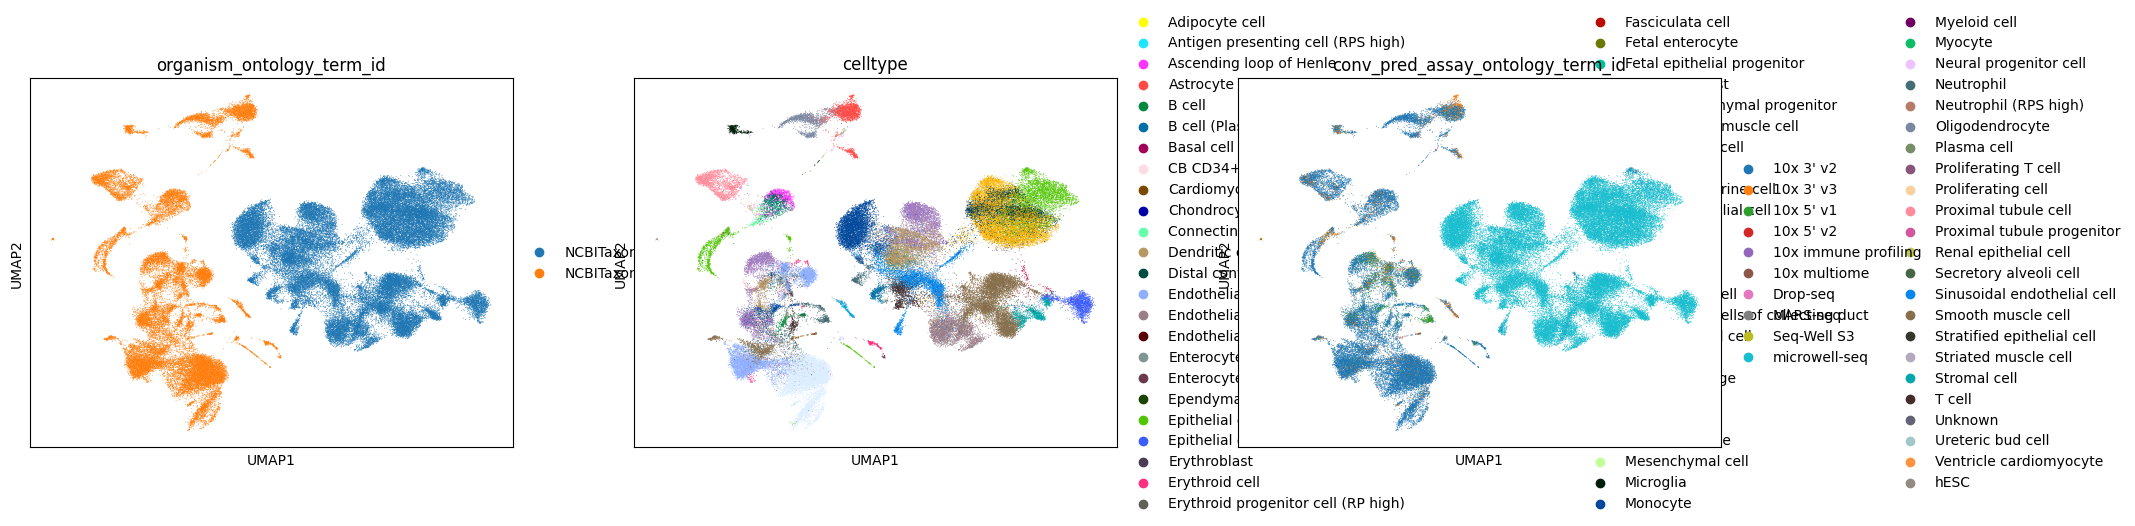

In [24]:
sc.pp.neighbors(pred, use_rep="scprint_emb")
sc.tl.umap(pred)
sc.pl.umap(
    pred,
    color=["organism_ontology_term_id", "celltype", "conv_pred_assay_ontology_term_id"],
)

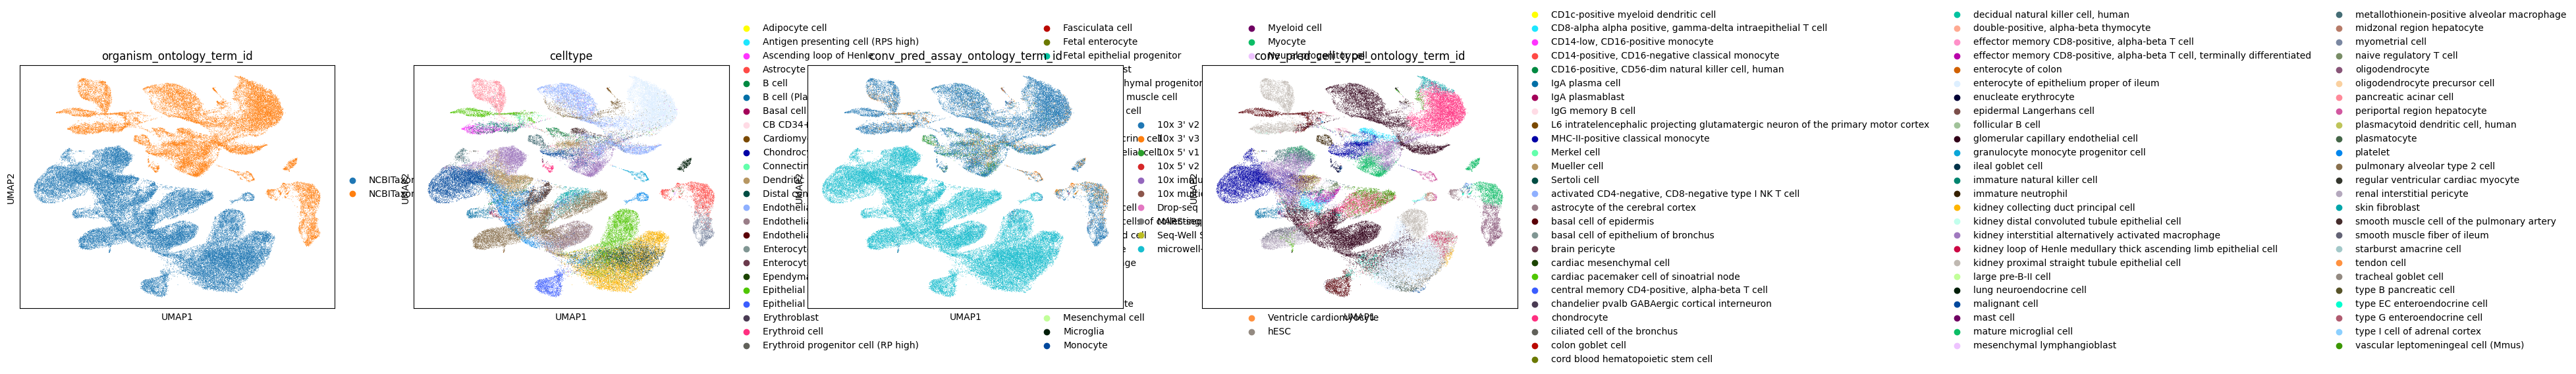

In [25]:
sc.pp.neighbors(pred, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(pred)
sc.pl.umap(
    pred,
    color=[
        "organism_ontology_term_id",
        "celltype",
        "conv_pred_assay_ontology_term_id",
        "conv_pred_cell_type_ontology_term_id",
    ],
)

In [ ]:
sc.pp.pca(n_adata)

In [ ]:
n_adata.obsm["random"] = np.random.rand(*n_adata.obsm["X_pca"].shape)

In [ ]:
n_adata

AnnData object with n_obs × n_vars = 27200 × 57186
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'cell_type', 'batch', 'barcode', 'celltype', 'percent.mt', 'integrated_snn_res.1', 'NewCelltype', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv

In [ ]:
bm = Benchmarker(
    n_adata,
    batch_key="orig.ident",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="NewCelltype",  # celltype
    embedding_obsm_keys=["scprint_emb", "X_pca", "random"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/miniconda3/envs/scprnt3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]Tue Aug 19 11:10:31 2025 INFO isolated labels: no more than 1 batches per label


INFO     11 clusters consist of a single batch or are too small. Skip.                                             


/home/ml4ig1/miniconda3/envs/scprnt3/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|███▎      | 1/3 [02:10<04:20, 130.03s/it]Tue Aug 19 11:12:41 2025 INFO isolated labels: no more than 1 batches per label


INFO     11 clusters consist of a single batch or are too small. Skip.                                             


/home/ml4ig1/miniconda3/envs/scprnt3/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  67%|██████▋   | 2/3 [04:03<02:00, 120.11s/it]Tue Aug 19 11:14:34 2025 INFO isolated labels: no more than 1 batches per label


INFO     11 clusters consist of a single batch or are too small. Skip.                                             


Metrics:  70%|███████   | 7/10 [01:56<00:25,  8.36s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprnt3/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 3/3 [06:00<00:00, 120.04s/it]


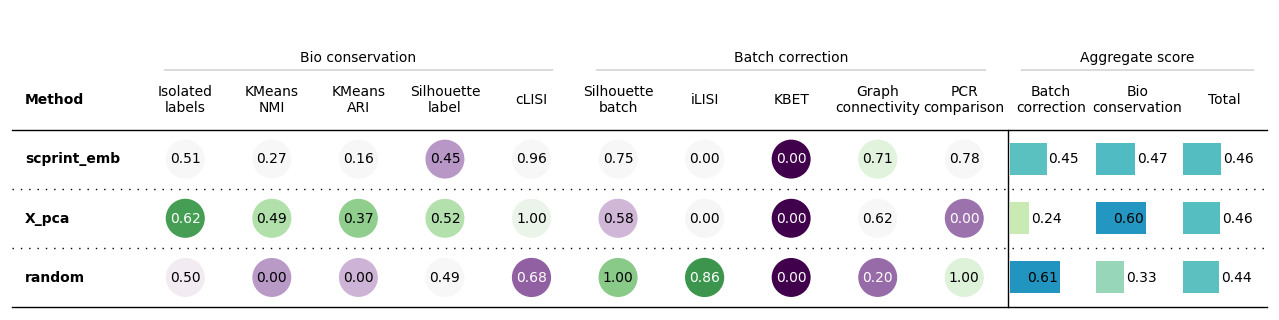

In [ ]:
bm.plot_results_table(min_max_scale=False)

# fine tuning a-la scanvi

In [19]:
from scprint.model import loss
from tqdm import tqdm
from scdataloader import SimpleAnnDataset, Collator
from torch.utils.data import DataLoader

- need to make labelling work with simpleAnnDataset
- add batch_cls and organism_cls

In [20]:
adataset = SimpleAnnDataset(
    da,
    obs_to_output=["batch", "cell_type"],
    get_knn_cells=model.expr_emb_style == "metacell",
)
col = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    how="random expr",
    max_len=3000,
    add_zero_genes=0,
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=32,
    num_workers=6,
    shuffle=True,
)
device = model.device.type
prevplot = model.doplot
model.on_fit_start()
model.configure_optimizers()

clsname = "cell_type_ontology_term_id"

NameError: name 'da' is not defined

In [ ]:
batch_cls = torch.nn.Sequential(
    torch.nn.Linear(model.d_model, model.d_model // 2),
    torch.nn.ReLU(),
    torch.nn.Linear(model.d_model // 2, len(set(da.obs["batch"].unique()))),
)

In [ ]:
with torch.autocast(device_type=model.device.type, dtype=model.dtype):
    for batch in tqdm(dataloader):
        gene_pos, expression, depth, batch_labels, cell_type_labels = (
            batch["genes"].to(model.device),
            batch["x"].to(model.device),
            batch["depth"].to(model.device),
            batch["batch"].to(model.device),
            batch["cell_type"].to(model.device),
        )
        output = model.forward(gene_pos, expression, depth)
        loss_cls = 0
        loss_cls += loss.hierarchical_classification(
            pred=output["cls_output_" + clsname],
            cl=batch["cell_type"],
            labels_hierarchy=model.mat_labels_hierarchy[clsname],
        )
        pos = model.classes.index("cell_type_ontology_term_id")
        loc = (
            pos  # Assuming 'j' correctly corresponds to 'assay_ontology_term_id' index
            + ((len(model.classes) + 1) if not model.cell_transformer else 0)
        )
        # Apply gradient reversal to the input embedding
        adv_input_emb = loss.grad_reverse(
            output["input_cell_embs"][:, loc, :].clone(), lambd=1.0
        )
        # Get predictions from the adversarial decoder
        adv_pred = model.adv_cls_decoder(adv_input_emb)

        # Compute the adversarial loss
        current_adv_loss = loss.hierarchical_classification(
            pred=adv_pred,
            cl=cell_type_labels,  # Use the true label for the adversarial target class
            labels_hierarchy=model.mat_labels_hierarchy[clsname]
            if clsname in model.mat_labels_hierarchy.keys()
            else None,
        )